In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Read
df = pd.read_csv('train.csv', names=["Date_Time", "y"], header=None )

df = df.iloc[1:]

df = df.dropna()

df['Date_Time'] = pd.to_datetime(df['Date_Time'],format='%d.%m.%y')
df['y'] = pd.to_numeric(df['y'])

df

,Date_Time,y
1,2015-01-01,1.91157
2,2015-02-01,1.44733
3,2015-03-01,1.89355
4,2015-04-01,2.03274
5,2015-05-01,2.27843
...,...,...
70,2020-10-01,2.21851
71,2020-11-01,2.01204
72,2020-12-01,1.97353
73,2021-01-01,2.19952


<AxesSubplot:xlabel='Date', ylabel='y'>

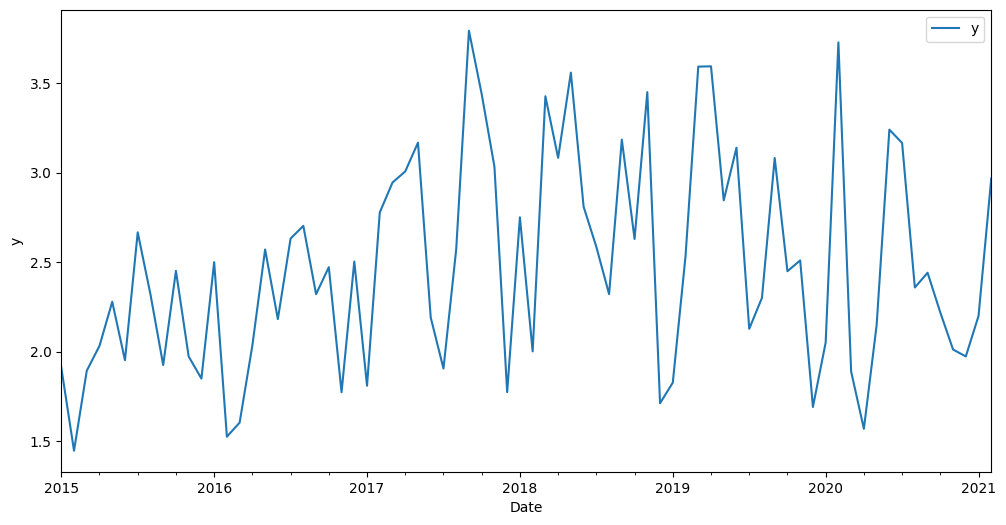

In [3]:
df.set_index('Date_Time').plot(figsize=(12,6), xlabel='Date', ylabel='y')

In [4]:
df_grouped = df.groupby(['Date_Time']).agg({'y': 'sum'}).reset_index()
df_grouped = df_grouped.set_index('Date_Time')

df_grouped

,y
Date_Time,
2015-01-01,1.91157
2015-02-01,1.44733
2015-03-01,1.89355
2015-04-01,2.03274
2015-05-01,2.27843
...,...
2020-10-01,2.21851
2020-11-01,2.01204
2020-12-01,1.97353


In [5]:
y = pd.Series(df["y"].values, index=pd.PeriodIndex(df["Date_Time"].values, freq="M"))
y

2015-01    1.91157
2015-02    1.44733
2015-03    1.89355
2015-04    2.03274
2015-05    2.27843
            ...   
2020-10    2.21851
2020-11    2.01204
2020-12    1.97353
2021-01    2.19952
2021-02    2.96740
Freq: M, Length: 74, dtype: float64

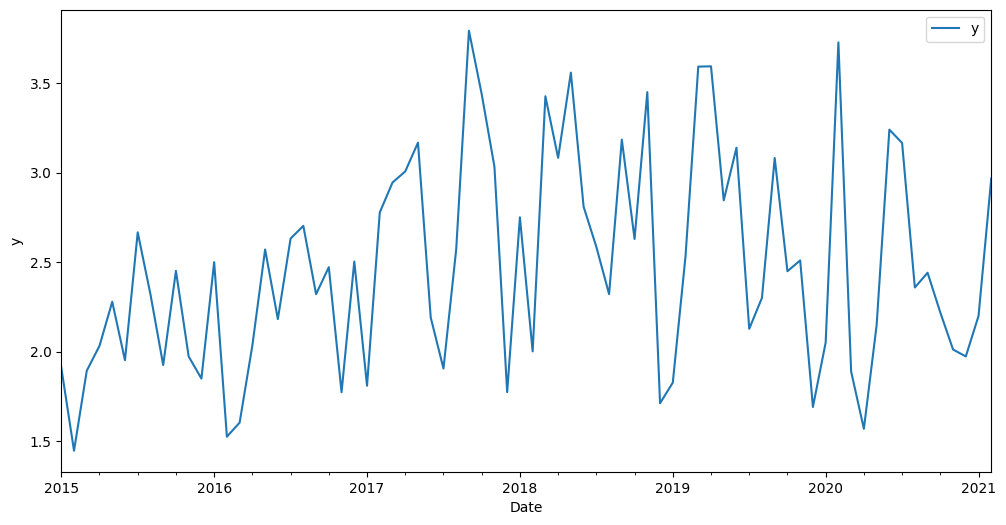

In [6]:
df.plot(x = "Date_Time", figsize=(12,6), xlabel='Date', ylabel='y')
plt.show()

### ¿stationary?

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_grouped.values.flatten())

print('ADF Statistic: %f' % result[0])
print(f"p-value: {result[1]}")

ADF Statistic: -6.156135
p-value: 7.360988139166811e-08


pvalue (0) < 0.05 -> null hypothesis can be rejected. ( Ho )

Ha  can be accepted -> the residue series is stationary.

Ho -> the residue series is not stationary.

### Our data seems appears to be stationary.

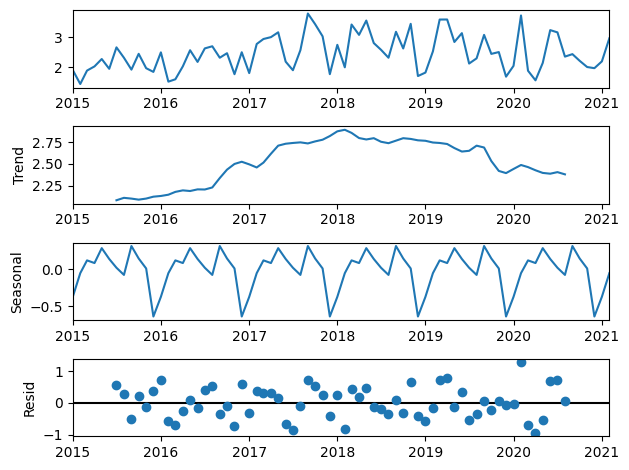

In [8]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposed = seasonal_decompose(x = df.set_index("Date_Time"), model='additive', period=12)

# Plot the decomposed time series
decomposed.plot();

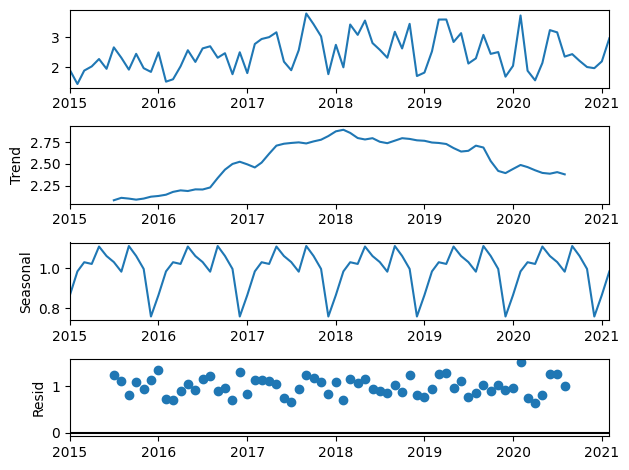

In [9]:
decomposed = seasonal_decompose(x = df.set_index("Date_Time"), model='multiplicative', period=12)

# Plot the decomposed time series
decomposed.plot();

<AxesSubplot:xlabel='Date_Time'>

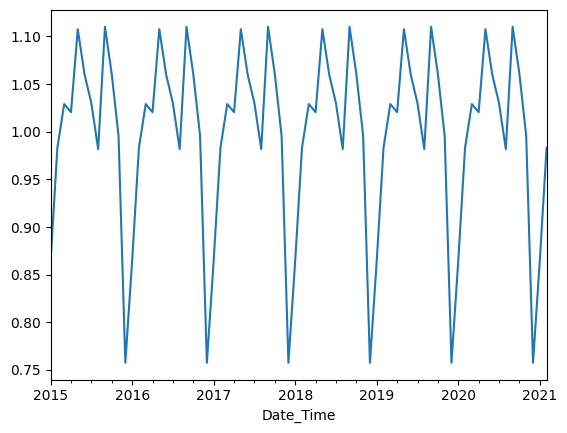

In [10]:
decomposed.seasonal.plot()

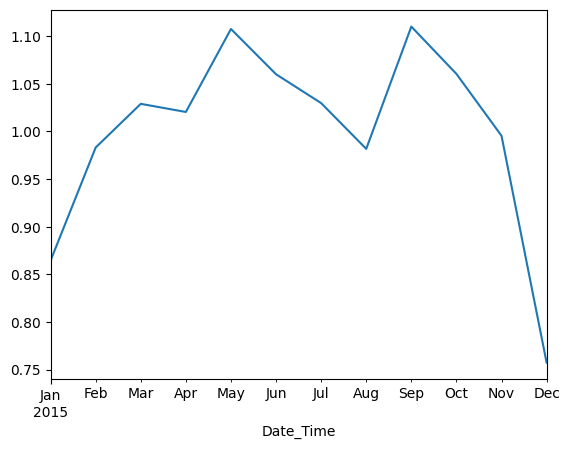

In [11]:
decomposed.seasonal["2015"].plot();

# End of year downturn, beginning of year recovery. the months of May and July there are peaks

<AxesSubplot:xlabel='Date_Time'>

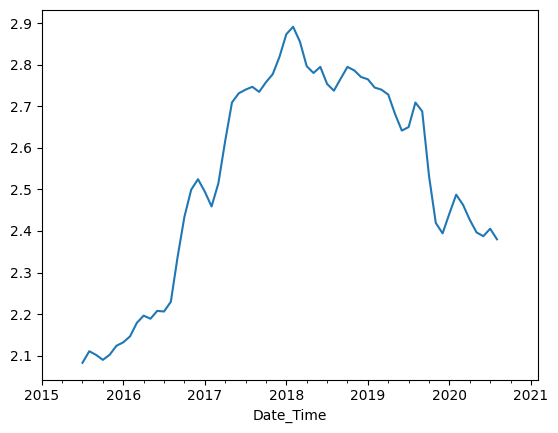

In [12]:
decomposed.trend.plot()
# It can be seen that the trend was upward until 2018, which begins in a downward trend.

<AxesSubplot:xlabel='Date_Time'>

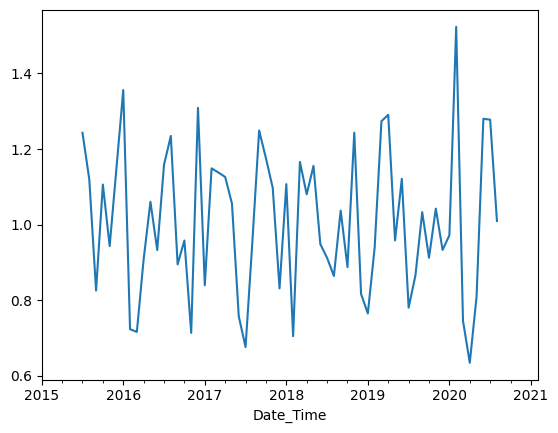

In [13]:
decomposed.resid.plot()

### Autocorrelation

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

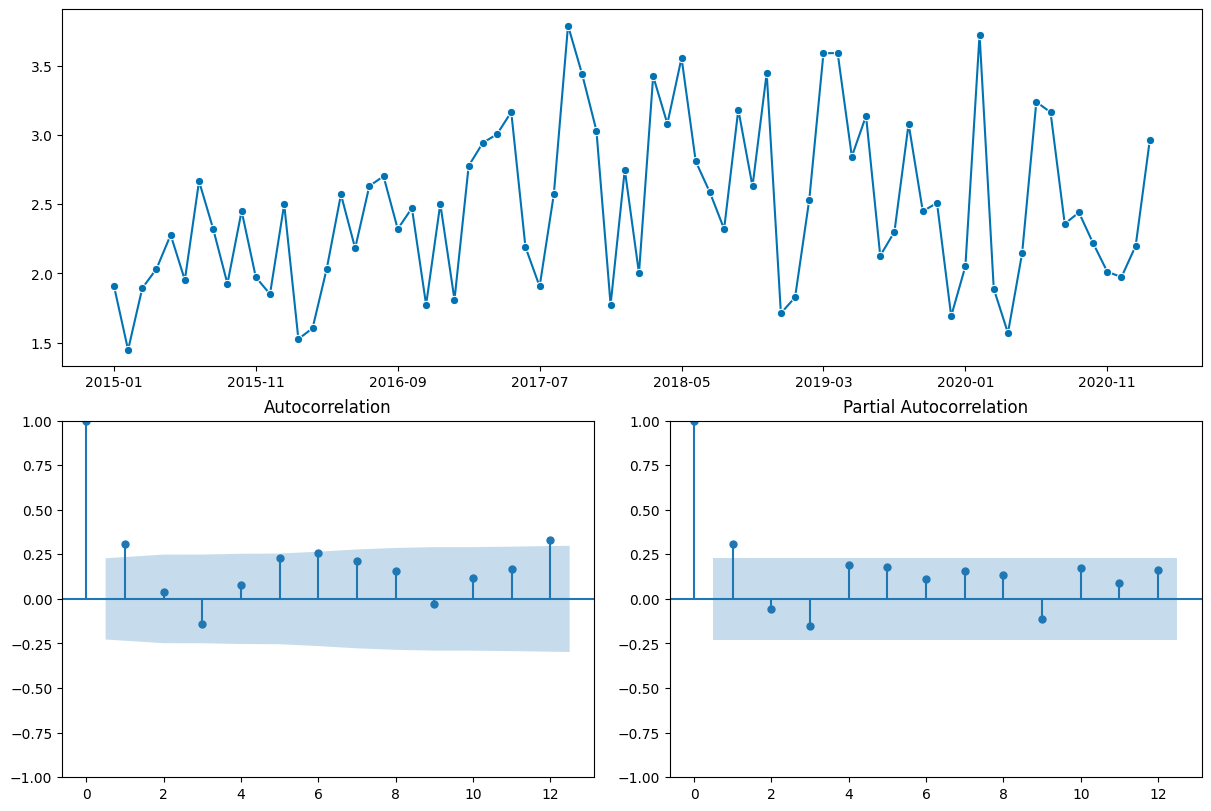

In [14]:
from sktime.utils.plotting import plot_correlations

plot_correlations(y, lags=12)

The autocorrelation confirms that we have a stationary time series. This is because the compensation with lag 1,2,3 is very low. In other words, y(t-1) does not depend on y(t-2).

In addition, the autocorrelation has two important peaks arround 1 and 12, that means that they are statistically significant.


ARIMA?

# the series contains seasonality but no trend (at least after 2018)

In [15]:
rolling_mean = df_grouped.rolling(8).mean()
rolling_std = df_grouped.rolling(8).std()

In [16]:
print(df_grouped.mean().values[0])
print(df_grouped.std().values[0])

2.474047162162162
0.5930020389429251


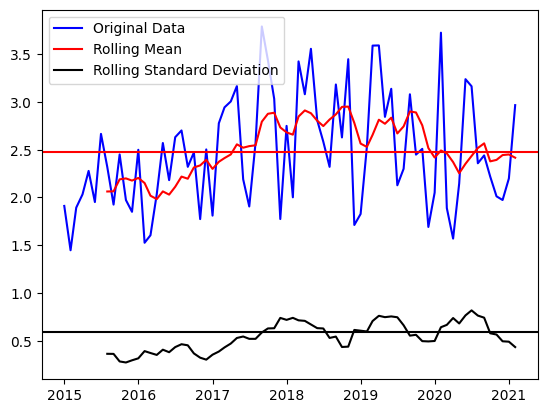

In [17]:
plt.plot(df_grouped, color="blue",label="Original Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")
plt.axhline(y=df_grouped.std().values[0], color='black', linestyle='-')
plt.axhline(y=df_grouped.mean().values[0], color='red', linestyle='-')
plt.legend(loc="best")

### We can see that the standard deviation varies between the value 0.5. We can give it as a constant.

### On the other hand, the average suffers some fluctuations but we can also determine that it is almost constant over time and is around the value 2.5.

# We have a stationary time series.

In [18]:
from statsmodels.tsa.stattools import adfuller

# Doble check

adft = adfuller(df_grouped,autolag="AIC",maxlag=12)

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -6.156135e+00              Test Statistics
1  7.360988e-08                      p-value
2  0.000000e+00             No. of lags used
3  7.300000e+01  Number of observations used
4 -3.523284e+00          critical value (1%)
5 -2.902031e+00          critical value (5%)
6 -2.588371e+00         critical value (10%)


#  data is stationary (NO TREND)

### I have created a class that allows me to create several models with just two clips. Additionally, you can configure the parameters of the different models through the YAML file that is seen in the project (in the config folder)

# I know my time series has seasonality. SARIMA models work very well in these types of cases. In the class I created, I use the autoarima function, which in principle is to create ARIMA models. If you enter the seasonality parameters, it creates a SARIMA model. This can be seen in the code but also in the YAML file in the "start_params_seasonal" and "max_params_seasonal" fields.

Additionally, I am going to use models like linear regression or XGB. For better prediction, I will have to remove the seasonality part of my time series. This is activated when creating the class and setting the deseasonalize parameter to True.

In [19]:
import os
import yaml
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from tqdm.auto import tqdm
from datetime import datetime
from sktime.forecasting.compose import make_reduction
from sklearn.linear_model import LinearRegression
from sktime.forecasting.model_selection import SingleWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from xgboost import XGBRegressor
from datetime import date, timedelta
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils import plotting




class Forecasting_time_series():


    def __init__(self, methods_list: list =["ARIMA", "LinearRegression", "XGB", "EXPONENTIAL_SMOOTHING"], y: pd.Series = pd.Series(), detrend: bool = False, deseasonalize: bool = False):

        """
        Class designed for forecasting time series using various methods such as ARIMA, Linear Regression, XGBoost, 
        and Exponential Smoothing. This class enables the fitting of models, making predictions, and handling 
        input parameters through a YAML file.

        Main methods:
            * **fit**: Fits models specified in the methods list.
            * **predict**: Makes predictions within a specified date range.
            
        Attributes:
            :param methods_list: List of forecasting methods to be used. Optional.
            :type methods_list: list
            :param y: Time series data to be modeled. Optional.
            :type y: pd.Series
            :param detrend: Indicates whether to apply detrending to the time series. Optional.
            :type detrend: bool
            :param deseasonalize: Indicates whether to apply deseasonalization to the time series. Optional.
            :type deseasonalize: bool
            :param config_file: Path to the YAML file with input parameters. Optional.
            :type config_file: str
        """

        self.methods_list = methods_list
        self.fit_dict = {}
        self.predict_dict = {}
        self.inputs_parameters = {}
        self.y = y
        self.fh = None
        self.X_pred = None

        self.detrend = detrend
        self.deseasonalize = deseasonalize

        # self.models_type = models_type

        CONFIG_FILE = "config\inputs.yaml"

        with open(CONFIG_FILE) as file:
            yaml_data = yaml.safe_load(file)
            self.inputs_parameters = yaml_data



    def fit(self, methods: list = None):
        """
        Fits the forecasting models according to the methods specified in `methods_list`.
        Updates the `fit_dict` dictionary with the fitted models.

        :return: Dictionary with the fitted models.
        :rtype: dict
        """
            
        self.methods_list = methods if methods is not None else self.methods_list

        self.__call_fit_methods(self.methods_list)

        return self.fit_dict
    
    def predict(self, start_date: datetime, end_date: datetime):
        """
        Makes predictions for the specified date range using the fitted models.
        Calculates the number of months between start and end dates and generates a data frame with predictions.

        :param start_date: Start date for the predictions.
        :type start_date: datetime
        :param end_date: End date for the predictions.
        :type end_date: datetime

        :return: DataFrame with predictions from each model.
        :rtype: pd.DataFrame
        """

        # start date
        d1 = datetime.strptime(start_date, "%Y-%m")
        d2 = datetime.strptime(end_date, "%Y-%m")
        diff_month = self.__diff_month(d2, d1)

        index_date = pd.to_datetime(pd.date_range(d1,d2, 
              freq='MS').strftime("%Y-%m")).to_period("M")
        
        X_pred = pd.DataFrame({'month': index_date.month}, index=index_date)
        X_pred = pd.get_dummies(X_pred.astype(str), drop_first=True)
        self.X_pred = X_pred

        fh = np.arange(1, diff_month + 2, 1, dtype=int)

        self.fh = fh

        self.__call_predict_methods(self.fit_dict)

        return self.__create_dataframe_predictions()

       

    def __create_dataframe_predictions(self):
 
        y_prediction_models = [{key: list(self.predict_dict[key]["y_predict"].values)} for key in self.predict_dict.keys()]

        key_one = list(self.predict_dict.keys())[0]
        index_date = self.predict_dict[key_one]["y_predict"].index


        df_pred = pd.DataFrame()

        for d in y_prediction_models:
            for key, value in d.items():
                df_pred[key] = value


        df_pred = df_pred.set_index(index_date)

        return df_pred



    def __call_predict_methods(self, methods: dict = None):
        """
        Calls the specific predict methods for each forecasting model.

        :param methods_list: List of methods to predict.
        :type methods_list: list
        """
        return [self.__predict_method(method) for method in tqdm(methods)]


    def __predict_method(self, method: str):
        """Internal use only. Perform the prediction"""

        __error = False

        if method == 'ARIMA':
            return self.predict_ARIMA()

        elif method == 'LinearRegression':
            return self.predict_linear_regression()
        
        elif method == 'XGB':
            return self.predict_xgb()

        elif method == 'EXPONENTIAL_SMOOTHING':
            return self.predict_exponential_smoothing()

        # match method:
        #     case 'ARIMA':
        #         __error = not self.__fit_ARIMA()

        return __error
    
    def predict_xgb(self):
        """
        Predicts future values using the XGBoost model previously fitted. This function utilizes the forecasting
        horizon (fh) and feature matrix (X_pred) prepared in the predict method to generate predictions.

        If the XGBoost model is successfully applied, the prediction results are stored in the predict_dict.
        If an error occurs during prediction, it logs the failure under XGB to indicate an issue.

        :raises: Logs a failure in the predict_dict if an error occurs.
        :return: None
        """

        try:

            if self.fit_dict["XGB"]["XGB_FIT"] == "DONE":

                model = self.fit_dict["XGB"]["model_fit"]
                y_pred = model.predict(fh=self.fh, X=self.X_pred)
                self.predict_dict.update({"XGB": {f"XGB_PREDICT": "DONE", "y_predict": y_pred}})

        except:
            self.predict_dict.update({"XGB": {f"XGB_PREDICT": "FAIL"}})

    def predict_exponential_smoothing(self):
        """
        Executes predictions using the Exponential Smoothing model if it is marked as fitted. The prediction
        leverages the forecasting horizon (fh) alone as this method typically handles univariate series.

        Updates the prediction dictionary with the results if successful, or logs a failure under EXPONENTIAL_SMOOTHING
        in case of an exception, indicating issues during the prediction phase.

        :raises: Logs a failure in the predict_dict if an error occurs.
        :return: None
        """
        try:

            if self.fit_dict["EXPONENTIAL_SMOOTHING"]["EXPONENTIAL_SMOOTHING_FIT"] == "DONE":

                model = self.fit_dict["EXPONENTIAL_SMOOTHING"]["model_fit"]
                y_pred = model.predict(fh=self.fh)
                self.predict_dict.update({"EXPONENTIAL_SMOOTHING": {f"EXPONENTIAL_SMOOTHING_PREDICT": "DONE", "y_predict": y_pred}})

        except:
            self.predict_dict.update({"EXPONENTIAL_SMOOTHING": {f"EXPONENTIAL_SMOOTHING_PREDICT": "FAIL"}})

    
    def predict_linear_regression(self):
        """
        Generates forecasts using a Linear Regression model if previously fitted. It uses the forecasting
        horizon (fh) to predict future values based on the model.

        Success or failure of the prediction is recorded in the prediction dictionary, noting the outcome
        appropriately under the LinearRegression key.

        :raises: Updates the predict_dict with "FAIL" if there are any issues during prediction.
        :return: None
        """
        try:

            if self.fit_dict["LinearRegression"]["LinearRegression_FIT"] == "DONE":

                model = self.fit_dict["LinearRegression"]["model_fit"]
                y_pred = model.predict(fh=self.fh)
                self.predict_dict.update({"LinearRegression": {f"LinearRegression_PREDICT": "DONE", "y_predict": y_pred}})

        except:
                self.predict_dict.update({"LinearRegression": {f"LinearRegression_PREDICT": "FAIL"}})

    
    def predict_ARIMA(self):
        """
        Uses the ARIMA model for making predictions if the model has been fitted. The method utilizes the
        forecasting horizon (fh) to determine future points and makes predictions accordingly.

        The outcomes of the prediction are documented in the predict_dict, with successful predictions marked
        as "DONE" and failures due to exceptions logged as "FAIL".

        :raises: Captures any exceptions and logs a "FAIL" status in predict_dict for ARIMA.
        :return: None
        """

        try:

            if self.fit_dict["ARIMA"]["ARIMA_FIT"] == "DONE":

                model = self.fit_dict["ARIMA"]["model_fit"]
                y_pred = model.predict(fh=self.fh)
                self.predict_dict.update({"ARIMA": {f"ARIMA_PREDICT": "DONE", "y_predict": y_pred}})

        except:
                self.predict_dict.update({"ARIMA": {f"ARIMA_PREDICT": "FAIL"}})
            

    def __diff_month(self, d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month

    
    def __fit_method(self, method: str):

        """Internal use only. Perform the fits"""

        __error = False

        print(" \n \n ########################################################### ")
        print(f"Method: {method} \n ")

        if method == 'ARIMA':
            return self.fit_ARIMA()
        
        elif method == 'LinearRegression':
            return self.fit_linear_regression()
        
        elif method == 'XGB':
            return self.fit_xgb()
        
        elif method == 'EXPONENTIAL_SMOOTHING':
            return self.fit_exponential_smoothing()

        # match method:
        #     case 'ARIMA':
        #         __error = not self.__fit_ARIMA()

        return __error
    
    def __call_fit_methods(self, methods_list):
 
        return [self.__fit_method(method) for method in tqdm(methods_list)]
    

    def fit_exponential_smoothing(self):
        
        """
        Fits an exponential smoothing model to the time series `self.y` using a randomized parameter search.
        Specific parameters and trend type are extracted from `self.inputs_parameters`.

        It is most effective when the values of the time series follow a gradual trend and display seasonal behavior in which the values follow a repeated cyclical pattern over a given number of time steps.

        :raises Exception: Captures any exception that occurs during the fitting process and updates the dictionary
        `self.predict_dict` to reflect the failure of the fitting process.

        This method attempts to identify the best parameters for the exponential smoothing model by testing multiple
        combinations in a predefined parameter grid. The best model and its parameters are then stored within `self.fit_dict`.

        Usage:
            No direct inputs are required from the user side; it utilizes class attributes like `self.y` and `self.inputs_parameters`.
            Make sure that the necessary data and parameters are properly set before calling this method.

        Outputs:
            Updates `self.fit_dict` with the results of the fitting process, including model fit and parameter selection,
            and prints the best parameters and score to the console.
        """

        try:
        
            validation_size = 24
            cv = SingleWindowSplitter(window_length=len(self.y)-validation_size, fh=validation_size) 
            param_grid = {
            'forecaster__seasonal': self.inputs_parameters["EXPONENTIAL_SMOOTHING"]["estimator__seasonal"],
            'forecaster__sp': self.inputs_parameters["EXPONENTIAL_SMOOTHING"]["estimator__sp"],
            'forecaster__trend': self.inputs_parameters["EXPONENTIAL_SMOOTHING"]["estimator__trend"],
            }

            forecaster = TransformedTargetForecaster(
                [("forecaster", ExponentialSmoothing(trend = "add"))]
            )

            gscv = ForecastingRandomizedSearchCV(forecaster=forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)

            fit_model = gscv.fit(y=self.y)


            print(f"Best params: {fit_model.best_params_}")
            print(f"Best Score: {fit_model.best_score_}")

            self.fit_dict.update({"EXPONENTIAL_SMOOTHING": {f"EXPONENTIAL_SMOOTHING_FIT": "DONE", "model_fit": fit_model}})


        except Exception as error:

            print("An exception occurred:", error)
            self.predict_dict.update({"EXPONENTIAL_SMOOTHING": {f"EXPONENTIAL_SMOOTHING_FIT": "FAIL"}})
    
    def fit_xgb(self):
        """
        Fits an XGBoost regression model using a feature engineering pipeline and parameter tuning via randomized search.
        Adjustments for seasonality and trends are optional and controlled through the class attributes.

        :raises Exception: Handles any exceptions during the fitting process by logging the error and setting the status
        in `self.predict_dict` to indicate failure.

        The function uses features related to the time index (e.g., month) for the XGBoost regressor and performs cross-validation
        over a defined parameter space. Useful in scenarios where external regressors or time-based features are significant.

        Usage:
            Requires that the necessary configuration parameters are defined within `self.inputs_parameters` before invocation.
            External factors (if any) should be passed correctly to utilize the full potential of the model.

        Outputs:
            Updates `self.fit_dict` with information regarding the XGBoost model's performance and best-fit parameters.
            Outputs the best parameters and performance scores to the console.
        """

        try:
         
            validation_size = self.inputs_parameters["XGB"]["validation_size"]
            cv = SingleWindowSplitter(window_length=len(self.y)-validation_size, fh=validation_size) 
            window_length = self.inputs_parameters["XGB"]["window_length"]
            strategy = self.inputs_parameters["XGB"]["strategy"]
            param_grid = {
            'forecaster__estimator__max_depth': self.inputs_parameters["XGB"]["estimator__max_depth"],
            'forecaster__estimator__learning_rate': self.inputs_parameters["XGB"]["estimator__learning_rate"],
            'forecaster__estimator__n_estimators': self.inputs_parameters["XGB"]["estimator__n_estimators"],
            'forecaster__estimator__subsample': np.arange(0.5, 1.0, 0.1),
            'forecaster__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
            'forecaster__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            }
            # TO DO -> READ FROM YAML FILE

            tuple_deseasonalize = None
            tuple_detrend = None

            # Add Deseasonalizer
            if self.deseasonalize:

                part = {'deseasonalize__model': self.inputs_parameters["XGB"]["deseasonalize__model"],
                'deseasonalize__sp': self.inputs_parameters["XGB"]["deseasonalize__sp"]}
                param_grid.update(part)
                tuple_deseasonalize = ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12))

            # Add detrend
            if self.detrend:
                part = {'detrend__forecaster__degree': self.inputs_parameters["XGB"]["detrend__forecaster__degree"],}
                param_grid.update(part) 
                tuple_detrend = ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))

    
            regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
            forecaster = make_reduction(regressor, window_length=window_length, strategy=strategy)

            list_add = [("forecaster", forecaster)]

            if tuple_deseasonalize:
                list_add.append(tuple_deseasonalize)

            if tuple_detrend:
                list_add.append(tuple_detrend)

            forecaster = TransformedTargetForecaster(
                list_add
            )

            gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)

            X = pd.DataFrame({'month': self.y.index.month}, index=self.y.index)
            X = pd.get_dummies(X.astype(str), drop_first=True)      
            fit_model = gscv.fit(y=self.y, X=X)


            print(f"Best params: {fit_model.best_params_}")
            print(f"Best Score: {fit_model.best_score_}")

            self.fit_dict.update({"XGB": {f"XGB_FIT": "DONE", "model_fit": fit_model}})


        except Exception as error:
            # handle the exception
            print("An exception occurred:", error)

            self.predict_dict.update({"XGB": {f"XGB_FIT": "FAIL"}})


    def fit_linear_regression(self):
        """
        Fits a linear regression model to the series `self.y` using a reduction approach based on the specified strategy
        and window length from `self.inputs_parameters`.

        :raises Exception: Captures exceptions during the fitting process and marks the attempt as a failure in `self.predict_dict`.

        This method is straightforward in its application, aiming to provide a baseline model for time series forecasting.
        The window length and strategy are key to the model's structure and should be adjusted based on the temporal dynamics of the data.

        Usage:
            Directly uses `self.y` for fitting. Ensure this attribute contains the appropriate time series data.

        Outputs:
            Stores the results in `self.fit_dict`, specifically marking the model's fit status and storing the fit object.
        """

        try:

            strategy = self.inputs_parameters["LinearRegression"]["strategy"]
            window_length = self.inputs_parameters["LinearRegression"]["window_length"]

            regressor = LinearRegression()
            forecaster = make_reduction(regressor, window_length=window_length, strategy=strategy)
            fit_model = forecaster.fit(self.y)

            self.fit_dict.update({"LinearRegression": {f"LinearRegression_FIT": "DONE", "model_fit": fit_model}})

        except:
            self.predict_dict.update({"LinearRegression": {f"LinearRegression_FIT": "FAIL"}})
         



    
    

    def fit_ARIMA(self):

        """
        Fits an ARIMA model to the time series data in `self.y`, optimizing the model parameters based on the configuration
        specified in `self.inputs_parameters`. Utilizes AutoARIMA for automatic model selection based on the specified information criterion.

        :raises Exception: Catches exceptions, logging them and updating `self.predict_dict` to reflect the unsuccessful fit.

        This method is designed for sophisticated time series forecasting, allowing for automatic determination of the most suitable
        ARIMA configuration. The model fitting includes optional seasonality adjustments and uses historical data points to predict future values.

        Usage:
            Uses `self.y` as input and extracts configuration from `self.inputs_parameters`. Parameters like seasonality and model order are critical.

        Outputs:
            Updates `self.fit_dict` with the ARIMA model's details and prints the model summary and best model information to the console.
        """

        try:

            start_params = self.inputs_parameters["ARIMA"]["start_params"]
            max_params = self.inputs_parameters["ARIMA"]["max_params"]
            start_params_seasonal = self.inputs_parameters["ARIMA"]["start_params_seasonal"]
            max_params_seasonal = self.inputs_parameters["ARIMA"]["max_params_seasonal"]
            information_criterion = self.inputs_parameters["ARIMA"]["information_criterion"]
            sp = self.inputs_parameters["ARIMA"]["sp"]
            seasonal = self.inputs_parameters["ARIMA"]["seasonal"]

            method = AutoARIMA(start_p=start_params[0], d=start_params[1], start_q=start_params[2],
                    max_p=max_params[0], max_d=max_params[1],  max_q=max_params[2],
                    start_P= start_params_seasonal[0], D=start_params_seasonal[1], start_Q=start_params_seasonal[2],
                    max_P =max_params_seasonal[0], max_D=max_params_seasonal[1], max_Q=max_params_seasonal[2],
                    sp=sp,
                    seasonal=seasonal,
                    information_criterion=information_criterion,
                    trace = True,
                    suppress_warnings = True)

            fit_model = method.fit(y=self.y)

            summary_table = fit_model.summary()
            results_as_html = summary_table.tables[0].as_html()
            summary_table_pandas = pd.read_html(results_as_html, header=0, index_col=0)[0]
            win_model = summary_table_pandas["y"][0]
            print(f"Best Model: {win_model}")
            print(summary_table.tables[1])

            self.fit_dict.update({"ARIMA": {f"ARIMA_FIT": "DONE", "model_fit": fit_model}})


        except:
                self.predict_dict.update({"ARIMA": {f"ARIMA_FIT": "FAIL"}})

f:\GitHub\test_time_series\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
f:\GitHub\test_time_series\myenv\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [20]:
obj_forecasting = Forecasting_time_series(y = y)
obj_forecasting.fit()


print(obj_forecasting.fit_dict)

  0%|          | 0/4 [00:00<?, ?it/s]

 
 
 ########################################################### 
Method: ARIMA 
 
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=135.658, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=127.910, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=127.757, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=350.149, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=131.061, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=129.732, Time=0.22 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=129.681, Time=0.14 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=128.304, Time=0.22 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=130.824, Time=0.68 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=130.546, Time=0.07 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=129.401, Time=0.19 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=128.556, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=127.499, Time=0.11 sec
 ARIMA(1,0,0)(0,

 25%|██▌       | 1/4 [00:04<00:13,  4.60s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=130.939, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=159.945, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.133 seconds
Best Model: SARIMAX(1, 0, 0)x(0, 0, [1], 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8104      0.295      6.131      0.000       1.232       2.389
ar.L1          0.2609      0.109      2.388      0.017       0.047       0.475
ma.S.L12       0.2765      0.121      2.292      0.022       0.040       0.513
sigma2         0.2903      0.058      4.986      0.000       0.176       0.404
 
 
 ########################################################### 
Method: LinearRegression 
 
 
 
 ########################################################### 
Method: XGB 
 


 75%|███████▌  | 3/4 [00:44<00:15, 15.79s/it]

Best params: {'forecaster__estimator__subsample': 0.5, 'forecaster__estimator__n_estimators': 1000, 'forecaster__estimator__max_depth': 15, 'forecaster__estimator__learning_rate': 0.01, 'forecaster__estimator__colsample_bytree': 0.6, 'forecaster__estimator__colsample_bylevel': 0.7}
Best Score: 0.0026900378923544175
 
 
 ########################################################### 
Method: EXPONENTIAL_SMOOTHING 
 


f:\GitHub\test_time_series\myenv\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
100%|██████████| 4/4 [00:45<00:00, 11.41s/it]

Best params: {'forecaster__trend': 'add', 'forecaster__sp': 12, 'forecaster__seasonal': 'additive'}
Best Score: 0.008204605758401618
{'ARIMA': {'ARIMA_FIT': 'DONE', 'model_fit': AutoARIMA(D=0, d=0, max_D=5, max_P=5, max_Q=5, max_d=5, sp=12, start_P=0,
          start_Q=0, start_p=0, start_q=0, suppress_warnings=True, trace=True)}, 'LinearRegression': {'LinearRegression_FIT': 'DONE', 'model_fit': RecursiveTabularRegressionForecaster(estimator=LinearRegression(),
                                     window_length=24)}, 'XGB': {'XGB_FIT': 'DONE', 'model_fit': ForecastingRandomizedSearchCV(cv=SingleWindowSplitter(fh=26, window_length=48),
                              forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                             RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample

In [21]:
df_pred = obj_forecasting.predict(start_date="2021-03", end_date="2022-02")

print(obj_forecasting.predict_dict)

100%|██████████| 4/4 [00:00<00:00, 34.78it/s]

{'ARIMA': {'ARIMA_PREDICT': 'DONE', 'y_predict': 2021-03    2.271847
2021-04    2.140957
2021-05    2.358574
2021-06    2.625046
2021-07    2.678401
2021-08    2.432832
2021-09    2.406534
2021-10    2.383778
2021-11    2.340829
2021-12    2.364579
2022-01    2.394865
2022-02    2.500352
Freq: M, dtype: float64}, 'LinearRegression': {'LinearRegression_PREDICT': 'DONE', 'y_predict': 2021-03    2.167693
2021-04    2.016812
2021-05    2.824175
2021-06    2.739129
2021-07    2.929702
2021-08    2.194979
2021-09    2.514237
2021-10    2.916107
2021-11    2.296216
2021-12    2.362066
2022-01    2.444005
2022-02    2.575370
Freq: M, dtype: float64}, 'XGB': {'XGB_PREDICT': 'DONE', 'y_predict': 2021-03    2.211014
2021-04    2.259366
2021-05    2.611821
2021-06    2.837577
2021-07    2.692659
2021-08    2.401401
2021-09    2.654278
2021-10    2.815955
2021-11    2.600839
2021-12    2.295504
2022-01    2.415117
2022-02    2.704675
Freq: M, dtype: float64}, 'EXPONENTIAL_SMOOTHING': {'EXPONENTIAL_

### WE CAN USE THE PREDICTIONS LATER TO EVALUATE IT WITH THE TEST DATASETR

In [22]:
df_pred

,ARIMA,LinearRegression,XGB,EXPONENTIAL_SMOOTHING
2021-03,2.271847,2.167693,2.211014,2.672764
2021-04,2.140957,2.016812,2.259366,2.667768
2021-05,2.358574,2.824175,2.611821,2.875728
2021-06,2.625046,2.739129,2.837577,2.700163
2021-07,2.678401,2.929702,2.692659,2.628379
2021-08,2.432832,2.194979,2.401401,2.543822
2021-09,2.406534,2.514237,2.654278,2.905396
2021-10,2.383778,2.916107,2.815955,2.724351
2021-11,2.340829,2.296216,2.600839,2.573121
2021-12,2.364579,2.362066,2.295504,2.032268


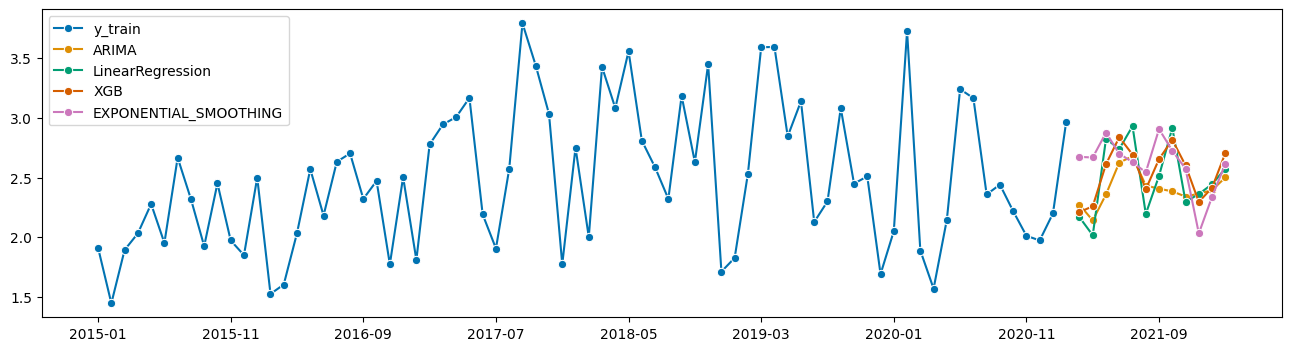

In [23]:
fig, ax = plotting.plot_series( y,  df_pred["ARIMA"], df_pred["LinearRegression"], df_pred["XGB"], df_pred["EXPONENTIAL_SMOOTHING"],
                               labels=["y_train", "ARIMA", "LinearRegression", "XGB", "EXPONENTIAL_SMOOTHING"])

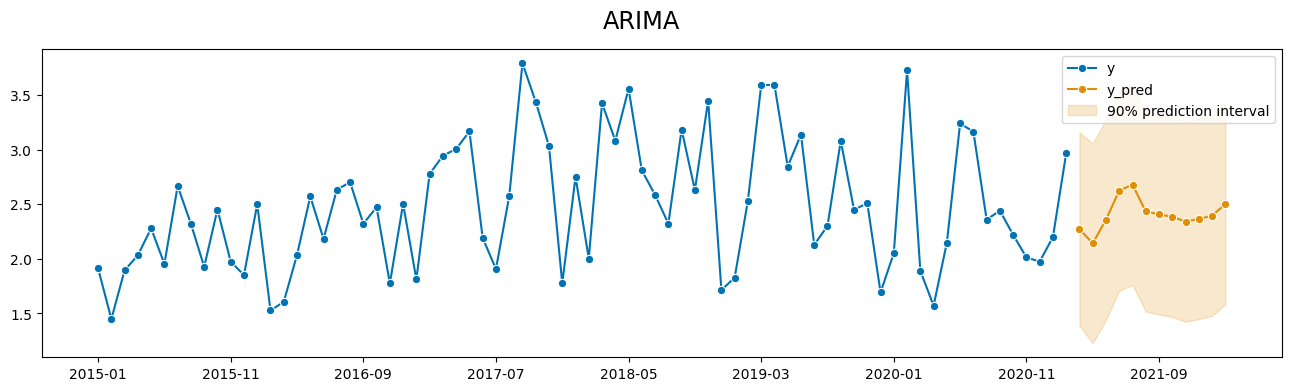

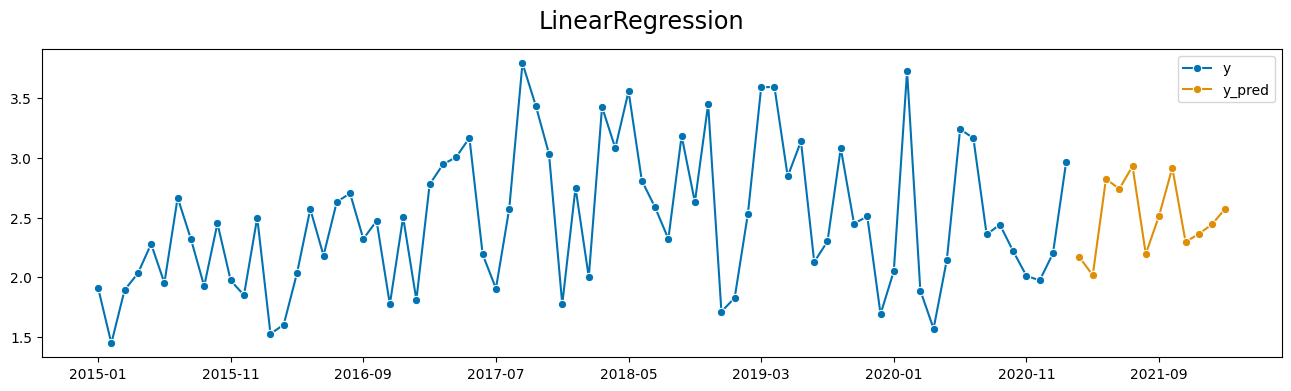

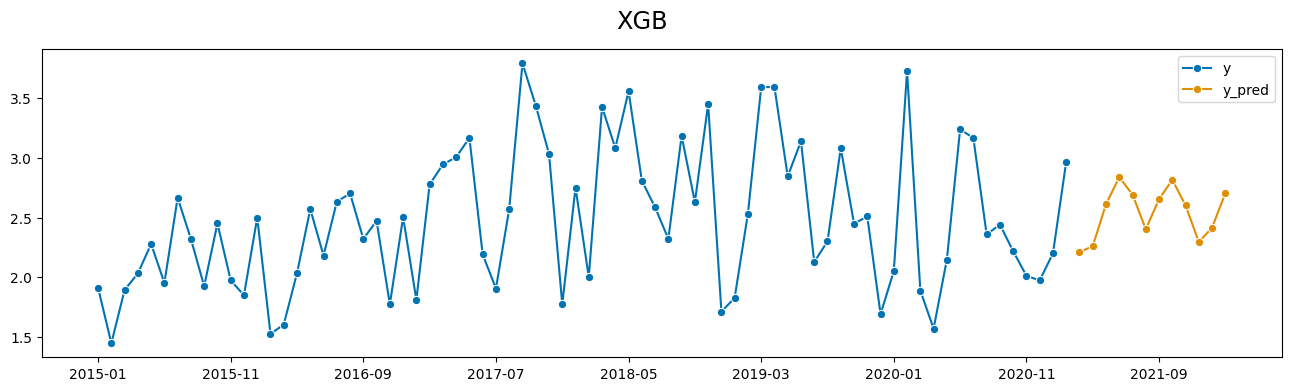

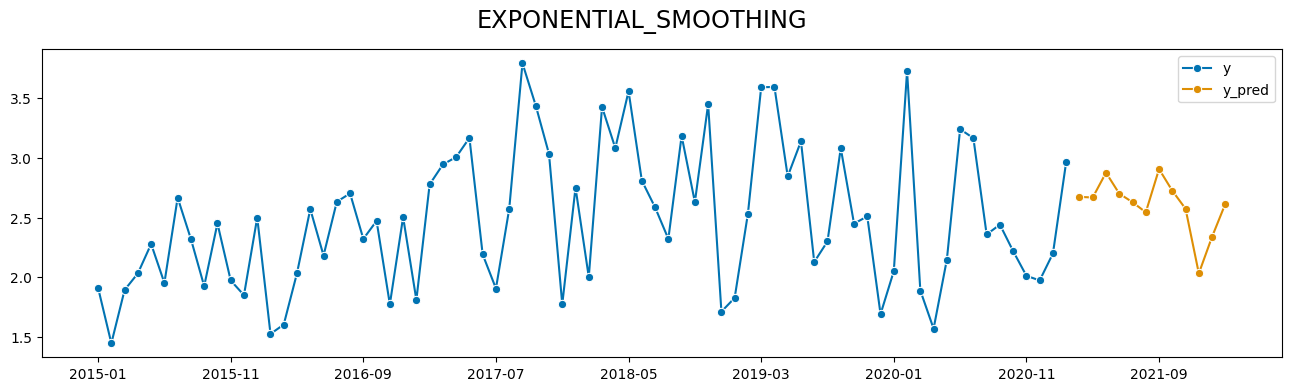

In [24]:
from sktime.utils import plotting

for key in obj_forecasting.fit_dict.keys():

    pred = obj_forecasting.predict_dict[key]["y_predict"]
    fit_model = obj_forecasting.fit_dict[key]["model_fit"]

    try:
        fig, ax = plotting.plot_series(
        y, pred, labels=["y", "y_pred"], title=key, pred_interval=fit_model.predict_interval())
    except:
        fig, ax = plotting.plot_series(
        y, pred, labels=["y", "y_pred"], title=key)

### Since we know that our time series has seasonality, let's remove it and create a new model using XGB.

  0%|          | 0/1 [00:00<?, ?it/s]

 
 
 ########################################################### 
Method: XGB 
 


100%|██████████| 1/1 [00:37<00:00, 37.84s/it]


Best params: {'forecaster__estimator__subsample': 0.7, 'forecaster__estimator__n_estimators': 500, 'forecaster__estimator__max_depth': 20, 'forecaster__estimator__learning_rate': 0.1, 'forecaster__estimator__colsample_bytree': 0.7, 'forecaster__estimator__colsample_bylevel': 0.8999999999999999, 'deseasonalize__sp': 3, 'deseasonalize__model': 'additive'}
Best Score: 0.0039203119668019


100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


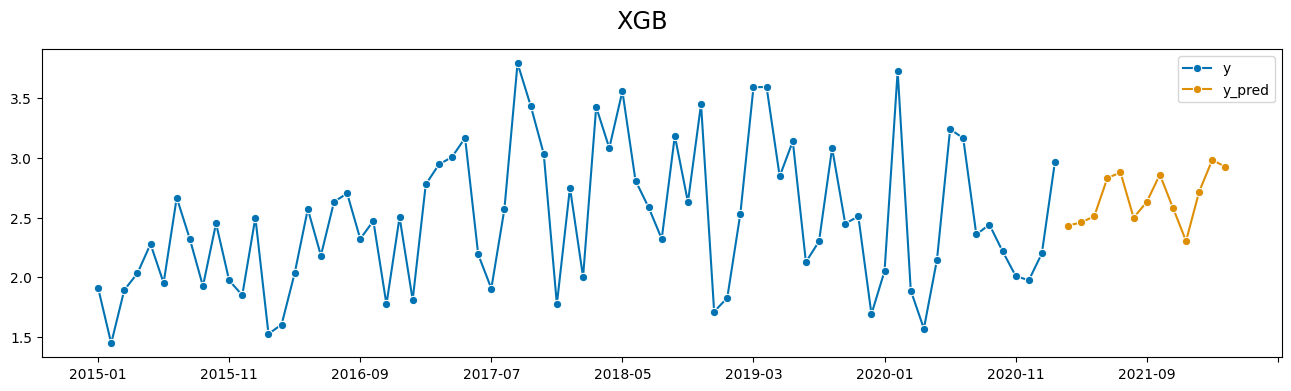

In [26]:
obj_forecasting_deseasonalize = Forecasting_time_series(y = y, methods_list=["XGB"], deseasonalize=True)
obj_forecasting_deseasonalize.fit()
df_pred_deseasonalize = obj_forecasting_deseasonalize.predict(start_date="2021-03", end_date="2022-03")


for key in obj_forecasting_deseasonalize.fit_dict.keys():
    pred = obj_forecasting_deseasonalize.predict_dict[key]["y_predict"]
    fit_model = obj_forecasting_deseasonalize.fit_dict[key]["model_fit"]

    try:
        fig, ax = plotting.plot_series(
        y, pred, labels=["y", "y_pred"], title=key, pred_interval=fit_model.predict_interval())
    except:
        fig, ax = plotting.plot_series(
        y, pred, labels=["y", "y_pred"], title=key)

In [27]:
df_pred_deseasonalize

,XGB
2021-03,2.432837
2021-04,2.458692
2021-05,2.511268
2021-06,2.831409
2021-07,2.877080
2021-08,2.498611
2021-09,2.629886
2021-10,2.859300
2021-11,2.581968
2021-12,2.303564
